# TS4

<img src="img/ejercicio1.png">
<img src="img/ejercicio2.png">

Se requiere diseñar un filtro que cumpla con la siguiente plantilla:

<img src="img/plantilla.png">


Lo primero que debemos hacer es normalizar la plantilla del pasabanda:

In [23]:
from sympy import  *
import numpy as np
from sympy.abc import s
from IPython.display import display, Math
from splane import pzmap, GroupDelay, bodePlot
from scipy.signal import TransferFunction
import matplotlib.pyplot as plt
import math as m

f_p1,f_p2,fo = symbols("fp1,fp2,fo")

ec1 = Eq(f_p1*f_p2,22000**2)
ec2 = Eq(f_p2-f_p1,4400)

respuesta = solve([ec1,ec2],f_p2,f_p1)#Salen varios resultados

f_p1 = float(respuesta[1][1])
f_p2 = float(respuesta[1][0])

print("fp1 =",f_p1)#tomamos los positivos
print("fp2 =",f_p2)

fp1 = 19909.72636646596
fp2 = 24309.72636646596


In [24]:
import math as m

f_s1 = 17e3
f_s2 = 36e3

w_s1 = f_s1*2*pi
w_s2 = f_s2*2*pi

f0 = m.sqrt(f_p1 * f_p2)

print(f'f0={f0}')

w0 = 2*pi*f0
w_p1 = 2*pi*f_p1
w_p2 = 2*pi*f_p2

w0_n = 1
w_p1_n = w_p1 / w0
w_p2_n = w_p2 / w0
w_s1_n = w_s1 / w0
w_s2_n = w_s2 / w0

print(f'w0_n={w0_n}')
print(f'w_p1_n={w_p1_n}, w_p2_n={w_p2_n}')
print(f'w_s1_n={w_s1_n}, w_s2_n={w_s2_n}')

f0=22000.0
w0_n=1
w_p1_n=0.904987562112089, w_p2_n=1.10498756211209
w_s1_n=0.772727272727273, w_s2_n=1.63636363636364


Ahora debemos hacer la transformacion:

$K(s)= Q * \frac{s^2 + 1}{s} = K(s)= 5 \frac{s^2 + 1}{s}$

In [25]:
Q = 5

Omega_p1 = Q * (w_p1_n ** 2 - 1) / w_p1_n
Omega_p2 = Q * (w_p2_n ** 2 - 1) / w_p2_n
Omega_s1 = Q * (w_s1_n ** 2 - 1) / w_s1_n
Omega_s2 = Q * (w_s2_n ** 2 - 1) / w_s2_n

print(f'Omega_p1={Omega_p1}, Omega_p2={Omega_p2}')
print(f'Omega_s1={Omega_s1}, Omega_s2={Omega_s2}')

Omega_p1=-1.00000000000000, Omega_p2=1.00000000000000
Omega_s1=-2.60695187165775, Omega_s2=5.12626262626262


Como vemos, $\Omega_{p1}=-1$ y $\Omega_{p2}=1$ como se buscaba. En cuanto a las  $\Omega_{s}$, tenemos que elegir una. Para ello elegimos la que tiene el modulo mas chico, ya que esta seria la que impone el requisito mas exigente en nuestro pasabajos.

Entonces elegimos:

$\Omega_{p}=1$

$\Omega_{s}=2.606951$

In [28]:
w_s_lp = abs(Omega_s1)

Ahora debemos empezar a diseñar nuestro filtro Chebyshev. 

Es importante ver que tenemos dos $\alpha_{min}$ en nuestra plantilla de pasabanda. La que utilizaremos es el $\alpha_{min}$ mas alto, de modo que se cumplan ambos requisitos. Entonces $\alpha_{min} = 24$ dB

In [29]:
alpha_max = 0.5    # dB
alpha_min = 24   # dB

epsilon = m.sqrt(m.pow(10, 0.1 * alpha_max) - 1)
N = m.acosh((m.pow(10, alpha_min * 0.1) - 1) / (m.pow(10, alpha_max * 0.1) - 1)) / (2 * m.acosh(w_s_lp))
N = m.ceil(N)

print(f'epsilon: {epsilon}, N: {N}')

epsilon: 0.34931140018894796, N: 3


Usamos la siguiente relacion: $c_n(\omega) = 2 \omega c_{n-1}(\omega) - c_{n-2}(\omega)$

$c_0(\omega) = 1$ , $c_1(\omega) = \omega$

$c_2(\omega) = 2\omega^2 -1$

$c_3(\omega) = 4\omega^3 -3\omega$

$\left | T(jw) \right |^{2} = \frac{1}{1+\epsilon^2 c_3(w)^2} $

$\left | T(jw) \right |^{2}  = \frac{1}{1+0.349^2 (4\omega^3 -3\omega)^2} $

In [49]:
w,T=symbols("w,T")
T = 1/(1+((0.349)**2)*(4*w**3 - 3*w)**2)


num, den = fraction(simplify(expand(T)))  #simplificamos y separamos numerador y denominador

display(T)

num = Poly(num,s)
den = Poly(den,s)

T = num/den
display(T)

1/(0.121801*(4*w**3 - 3*w)**2 + 1)

1/(1.948816*w**6 - 2.923224*w**4 + 1.096209*w**2 + 1.0)

Hacemos $\left | T(s) \right |^{2}$ con $\omega = \frac{s}{j}$

$\left | T(s) \right |^{2} = \frac{1}{-1.948816 s^6−2.923224 s^4-1.096209 s^2+1.0}$

array([-0.31339386+1.0220798j, -0.31339386-1.0220798j,
        0.31339386+1.0220798j,  0.31339386-1.0220798j,
       -0.62678771+0.j       ,  0.62678771+0.j       ])

(1, <AxesSubplot:xlabel='$\\sigma$', ylabel='j$\\omega$'>)

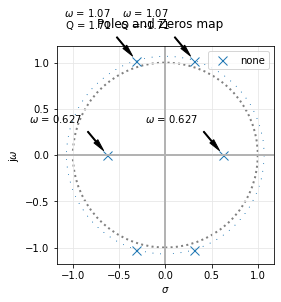

In [65]:
coeffs_den = [-1.948816,0,-2.923224,0,-1.096209,0,1]

root = np.roots(coeffs_den)

display(root)

my_tf = TransferFunction( [1], coeffs_den )

pzmap(my_tf, 4) #S plane pole/zero plot

array([-0.3144+1.02174001j, -0.3144-1.02174001j,  0.3144+1.02174001j,
        0.3144-1.02174001j, -0.6267+0.j        ,  0.6267+0.j        ])

(1, <AxesSubplot:xlabel='$\\sigma$', ylabel='j$\\omega$'>)

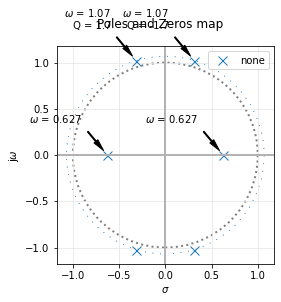

In [67]:
coeffs_den = [-1,0,-1.49745767,0,-0.563606179851482,0,0.512932069476418]

root = np.roots(coeffs_den)

display(root)

my_tf = TransferFunction( [0.512932069476418], coeffs_den )

pzmap(my_tf, 4) #S plane pole/zero plot

Recordamos que:

$\left | T(s) \right |^{2} =  T(s)*  T(-s)$

Lo que se puede hacer para hallar $T(s)$ es analizar los polos. Utilizo los que tienen parte real negativa, y calculo su $Q$ y $\omega_o$

In [58]:
wo_f = abs(root[0])
print("wo =",wo_f)

q = 1/(2*cos(atan(root[0].imag/root[0].real)))
print("Q =",q)

wo = 1.0690476291659607
Q = 1.70559762433925


$\left | T(s) \right | = \frac{1.06904^2}{(s + 0.6267)(s^2 + s\frac{1.06904}{1.7} + 1.06904^2)}$

In [68]:
s=symbols("s")
T = 0.7161923/((s+ 0.6267)*(s**2 +s*0.6288 + 1.1428))

num, den = fraction(simplify(expand(T)))  #simplificamos y separamos numerador y denominador

display(T)

num = Poly(num,s)
den = Poly(den,s)

T = num/den

0.7161923/((s + 0.6267)*(s**2 + 0.6288*s + 1.1428))

Ya tenemos la transferencia de nuestro prototipo pasabajos. Ahora hay que transformarlo en un pasabanda. Usamos la transformación para obtener la transferencia del pasabanda:

$T(s) = T_{LP}(Q * \frac{s^2 + 1}{s})$

In [131]:
T = (0.7161923/((s+ 0.6267)*(s**2 +s*0.6288 + 1.1428)))
num, den = fraction(simplify(expand(T)))  #simplificamos y separamos numerador y denominador

num = Poly(num,s)
den = Poly(den,s)

T = num/den

T = T.subs(s, 5*((s**2 +1)/s))
T = expand(T)

num, den = fraction(simplify(expand(T)))  #simplificamos y separamos numerador y denominador

num = Poly(num,s)
den = Poly(den,s)

T = num/den

display(T)

0.7161923/(1.0*s**3 + 1.2555*s**2 + 1.53686896*s + 0.71619276)

0.7161923*s**3/(125.0*s**6 + 31.3875*s**5 + 382.6843448*s**4 + 63.49119276*s**3 + 382.6843448*s**2 + 31.3875*s + 125.0)

array([-0.0346364 +1.10689119j, -0.0346364 -1.10689119j,
       -0.06267049+0.99803814j, -0.06267049-0.99803814j,
       -0.02824311+0.90254391j, -0.02824311-0.90254391j])

(1, <AxesSubplot:xlabel='$\\sigma$', ylabel='j$\\omega$'>)

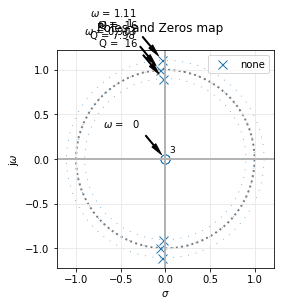

In [105]:
coeffs_den = [125,31.3875,382.6843,63.4911927,382.684344,31.3875,125]

root = np.roots(coeffs_den)

display(root)

my_tf = TransferFunction( [0.7161923,0,0,0], coeffs_den )

pzmap(my_tf, 6) #S plane pole/zero plot

In [132]:
den = den.monic() #hacemos que el numerador y denominador sean monicos
num = num/125
T = num/den

display(T)


0.0057295384*s**3/(1.0*s**6 + 0.2511*s**5 + 3.0614747584*s**4 + 0.50792954208*s**3 + 3.0614747584*s**2 + 0.2511*s + 1.0)

Con esto ya podemos ver si cumplimos las condiciones de la plantilla.

Graficando en matlab vemos que si se cumplen:

<img src="img/transferencia.png">

Para pasar al circuito debemos representar esta transferencia en tres transferencias de orden 2:

$T(s) =  T_1(s)*  T_2(s) * T_3(s)$

Para encontrar estas expresiones usamos los polos:

In [130]:
wo_1 = abs(root[0])
print("wo1 =",wo_1)
wo_2 = abs(root[2])
print("wo2 =",wo_2)
wo_3 = abs(root[4])
print("wo3 =",wo_3)

q1 = 1/(2*cos(atan(root[0].imag/root[0].real)))
print("Q1 =",q1)
q2 = 1/(2*cos(atan(root[2].imag/root[2].real)))
print("Q2 =",q2)
q3 = 1/(2*cos(atan(root[4].imag/root[4].real)))
print("Q3 =",q3)

wo1 = 1.1074329693319578
wo2 = 1.0000038546440502
wo3 = 0.9029857093509162
Q1 = 15.9865477198146
Q2 = 7.97826781377223
Q3 = 15.9859458099980


Un pasabanda tiene la siguiente transferencia:

$T(s)=\frac{s\frac{R}{L} }{s^2 + \frac{R}{L}s + \frac{1}{LC}}$

$T_1(s)=\frac{s\frac{1.107}{15.986}}{s^2 + \frac{1.107}{15.986}s + 1.107^2}$

$T_2(s)=\frac{s\frac{1}{7.9782}}{s^2 + \frac{1}{7.9782}s + 1}$

$T_3(s)=\frac{s\frac{0.9029}{15.986}}{s^2 + \frac{0.9029}{15.986}s + 0.9029^2}$

No logro llegar al circuito ya que los R/L me fuerza el numerador y no me queda igual que en el de la transferencia 